<h1 style="text-align: center;"><b>Longstaff-Schwarz/Least-Squares Method</b></h1>

#### Maksim Sosnin


Let $S$ be the price of the underlying, $V_t(S)$ – option value, $\Psi(S)$ – payoff, $T$ – maturity, $r$ – risk-free rate.

We can approximate American option with a Bermudan option, which can be exercised at specified discrete dates:
$$\Delta t := \frac{T}{M},\quad t_j := j \Delta t\ (j = 0, ..., M),$$
where $T$ is maturity, $M$ – number of time steps.

### Dynamic programming
$V_{t_M}(S) = \Psi(S)\ $ – payoff.

$C_{t_n}(S) := e^{-r \Delta t}\ \mathbb{E}[V_{t_{n+1}}(S_{t_{n+1}}) | S_{t_n} = S]\ $ – continuation or holding value. Needs to be approximated, e.g. by regression.

$V_{t_n}(S) = \max[C_{t_n}(S), \Psi(S)].$

### LSM algorithm (Monte-Carlo + Regression)
1. Simulate $N$ paths $S_1(t), ... , S_N(t)$ with $M$ time steps:
    $$S_{j,k} := S_k(t_j),\quad j = 1, ..., M,\ k = 1, ..., N.$$
2. For $k = 1, ..., N$ set
    - $g_k := \Psi(S_{M,k})$ – cashflow vector,
    - $\tau_k = M$ – integer stopping time vector.
3. For $j = M - 1, ..., 1$:
    For the subset of in-the-money points $(x_k, y_k) := (S_{j,k}, e^{-r(\tau_k-j)\Delta t} g_k)$:
    - Approximate $C_j(x)$ using suitable basis functions $\phi_0, ..., \phi_L$ (for example, monomials) by least squares over the ITM points:
        $$C_j(x) \approx \sum_{l=0}^L a_l \phi_l(x) =: \hat C_j(x).$$
    - For those $k$ with $\Psi(S_{j,k}) \geq \hat C_j(S_{j,k})$ update
        $$g_k := \Psi(S_{j,k}),\quad \tau_k := j.$$
4. Finally, set
    $$\hat C_0 := \frac{1}{N} \sum_{k=1}{N} e^{-r\tau_k \Delta t} g_k, \quad V_0 := \max\{\Psi(S_0), \hat C_0\}.$$


For more in-depth explanation of LSM algorithm, see [Seydel2017, section 3.6.3] and the original article [LongstaffSchwartz2001].

In [1]:
import torch
import numpy as np
import jax
import jax.numpy as jnp
from scipy.optimize import minimize
from functools import partial
import matplotlib.pyplot as plt
from torch.utils.cpp_extension import load

from jax.config import config
config.update("jax_enable_x64", True)

torch.set_default_tensor_type(torch.DoubleTensor)

!mkdir -p build
NOA_LOCATION = '../..'

In [2]:
N_PATHS = 1_500_000
N_STEPS = 250
DT = 1 / 250

SIGMA = 0.3
S0 = 100
STRIKE = S0 * 0.85
RATE = 0.03

In [3]:
def generate_gbm(n_paths, n_steps, dt, S0, sigma, drift):
    paths_gbm = S0 * torch.cumprod(
        1 + drift*dt + sigma * (dt**0.5) * torch.randn((n_paths, n_steps)), dim=1)
    paths_gbm = torch.hstack((S0 * torch.ones((n_paths, 1)), paths_gbm))
    return paths_gbm

In [4]:
paths_gbm = generate_gbm(N_PATHS, N_STEPS, DT, S0, SIGMA, RATE)

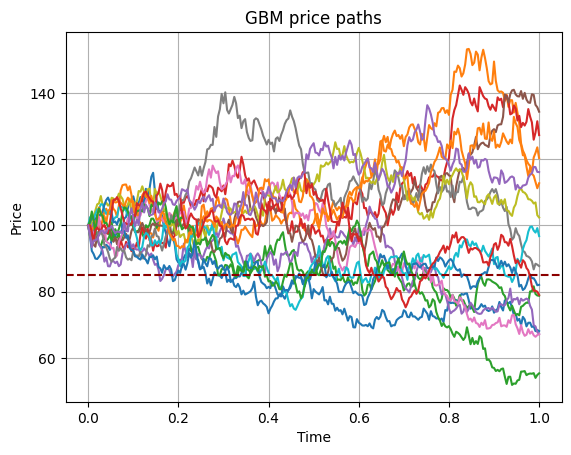

In [5]:
time_arr = np.linspace(0, N_STEPS * DT, N_STEPS + 1)
for i in range(15):
    plt.plot(time_arr, paths_gbm.detach().numpy()[i])
plt.axhline(STRIKE, ls='--', label='Strike', c='darkred')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('GBM price paths')
plt.grid()
plt.show()

# LSM algorithm implementation

In [6]:
%pycat pyquant/lsm.py

"""
References:
    [Seydel2017] Seydel, Rüdiger. Tools for computational finance.
    Sixth edition. Springer, 2017. Section 3.6.3.
"""


import torch
from dataclasses import dataclass
from typing import Optional, List


@dataclass
class LSMResult:
    """Represents the computation result of LSM algorithm.

    Attributes:
        option_price:
            Price of the option at initial moment of time. Shape: (1, ).
        stop_S_vals:
            Price values of the underlying for early exercise curve.
        stop_t_vals:
            Time values for early exercise curve.
        C_hats:
            Continuation value approximations for in-the-money subset of
            underlying paths at each moment of time. Length: N_STEPS + 1
        y_vals:
            Values of dependent variable for regression for in-the-money
            subset of underlying paths at each moment of time Length: N_STEPS + 1.
        paths_itm_vals:
            Values of in-the-money subset of underlying path

In [7]:
from pyquant.lsm import price_american_put_lsm
lsm_res = price_american_put_lsm(paths_gbm, DT, STRIKE, RATE, return_extra=True)

In [8]:
stop_S_lsm = lsm_res.stop_S_vals.numpy()
stop_t_lsm = lsm_res.stop_t_vals.numpy()

In [9]:
print(f'Price of American put: {lsm_res.option_price}')

Price of American put: 4.351371802851156


## Visualization of LSM algorithm

Let's look at the computed approximations of continuation value curves $\hat C_j (x)$ and in-the-money points $(x_k, y_k) := (S_{j,k}, e^{-r(\tau_k-j)\Delta t} g_k)$ – the data for regression, at different time steps $j$.

In [10]:
def visualize_lsm(idx):
    itm_index = paths_gbm[:, idx] < STRIKE
    C_hat = lsm_res.C_hats[idx]

    plt.figure(figsize=(9, 6))
    plt.scatter(lsm_res.paths_itm_vals[idx], lsm_res.y_vals[idx], s=.15,
                label='ITM points $(x_k, y_k)$')
    plt.scatter(paths_gbm[:, idx][itm_index], C_hat, s=2,
                label='Continuation value $\hat C_j(x)$')

    S_space = np.linspace(min(paths_gbm[:, idx]).item() - 7, max(paths_gbm[:, idx]).item() + 7, 1000)
    payoff = np.maximum(STRIKE - S_space, 0)
    plt.plot(S_space, payoff, color='black', label='Payoff $\Psi(S)$', lw=2)
    plt.axvline(STRIKE, ls='--', label='Strike', c='darkred', lw=1)

    plt.xlim(min(S_space), 120)
    plt.ylim(-7, max(payoff) + 7)
    plt.xlabel('S')
    plt.title(f'j = {idx}, n_steps = {N_STEPS}')
    legend = plt.legend()
    legend.legend_handles[0]._sizes=[30]
    legend.legend_handles[1]._sizes=[30]
    plt.show()

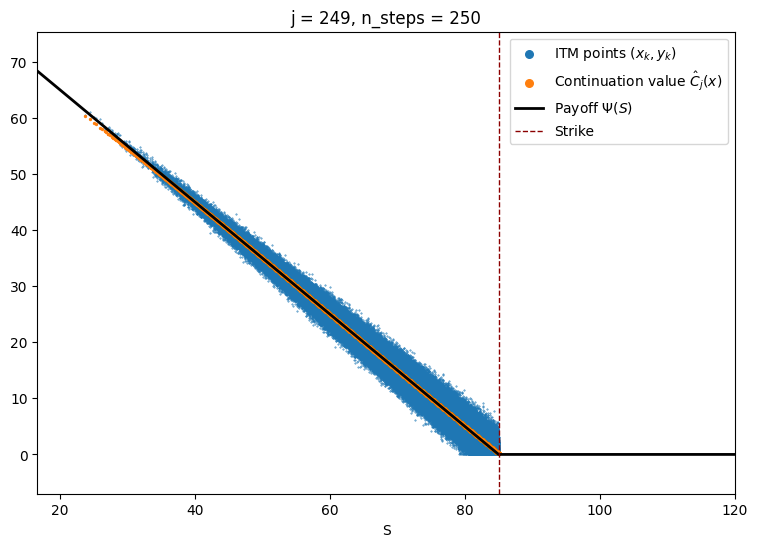

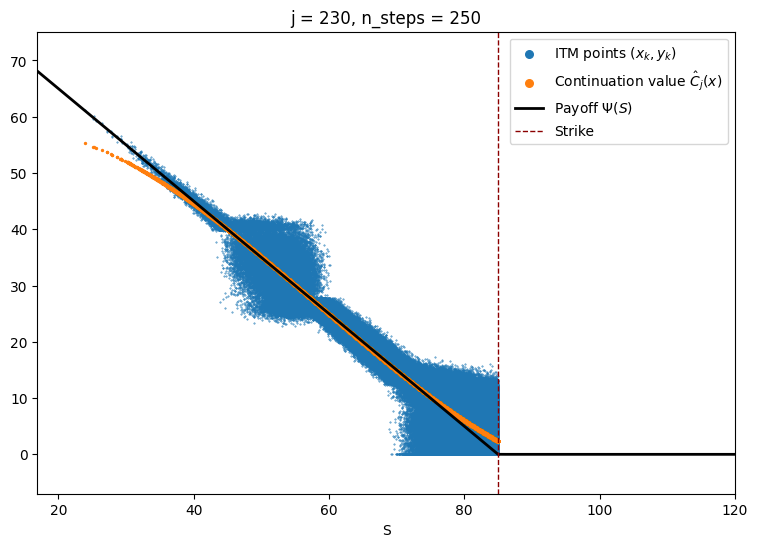

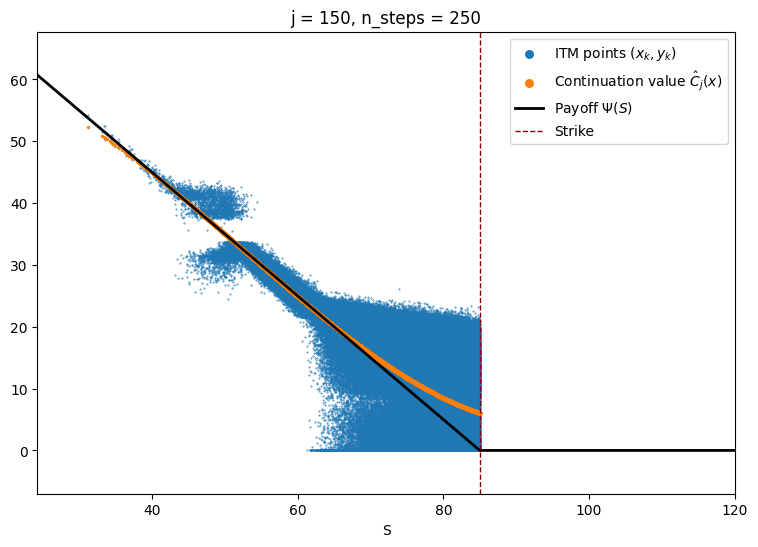

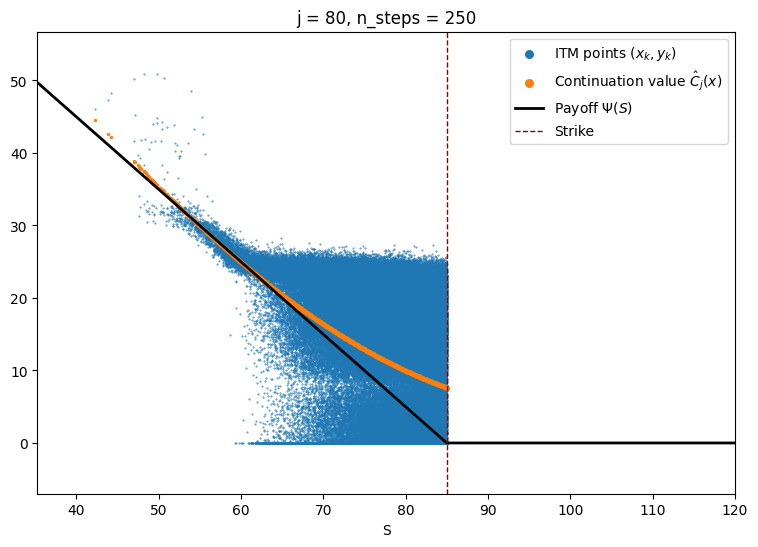

In [11]:
visualize_lsm(N_STEPS - 1)
visualize_lsm(N_STEPS - 20)
visualize_lsm(N_STEPS - 100)
visualize_lsm(N_STEPS - 170)

## Early-exercise curve

With LSM algorithm we have naturally obtained an estimate of the early-exercise curve. We can now fit a smooth curve to this estimate. We will ensure that the curve is increasing and convex by using optimization with constraints on first and second derivatives.

In [12]:
@jax.jit
def early_fun(t, coefs):
    return jnp.polyval(coefs, t)

@jax.jit
def loss(coefs):
    return jnp.mean((stop_S_lsm[IDX_START:] - early_fun(stop_t_lsm[IDX_START:], coefs)) ** 2)

# first derivative wrt `t`
@jax.jit
def constr_d1(coefs, t):
    return jax.grad(partial(early_fun, coefs=coefs))(t)

# second derivative wrt `t`
@jax.jit
def constr_d2(coefs, t):
    return jax.grad(jax.grad(partial(early_fun, coefs=coefs)))(t)

def fit_early_curve(poly_degree, time_arr_early):
    init_guess = np.random.normal(loc=0, scale=2, size=poly_degree+1)
    constraints = \
        [
            dict(
                type='ineq',
                fun=partial(constr_d1, t=t_val),
            ) for t_val in time_arr_early
        ] + \
        [
            dict(
                type='ineq',
                fun=partial(constr_d2, t=t_val),
            ) for t_val in time_arr_early
        ]

    res = minimize(
        loss,
        init_guess,
        jac=jax.grad(loss),
        method='SLSQP',
        constraints=constraints
    )
    return res

In [13]:
IDX_START = 20
POLY_DEGREE = 5
time_arr_early = np.arange(lsm_res.stop_t_vals[IDX_START], DT * N_STEPS, DT)

early_fit_res = fit_early_curve(POLY_DEGREE, time_arr_early)
early_fit_res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.1056043023773075
       x: [ 2.209e+00  1.595e+00  2.484e+00  1.454e+01 -5.395e+00
            6.082e+01]
     nit: 22
     jac: [ 4.161e-04 -3.361e-04 -1.561e-04  9.363e-04  1.705e-03
           -1.142e-04]
    nfev: 23
    njev: 22

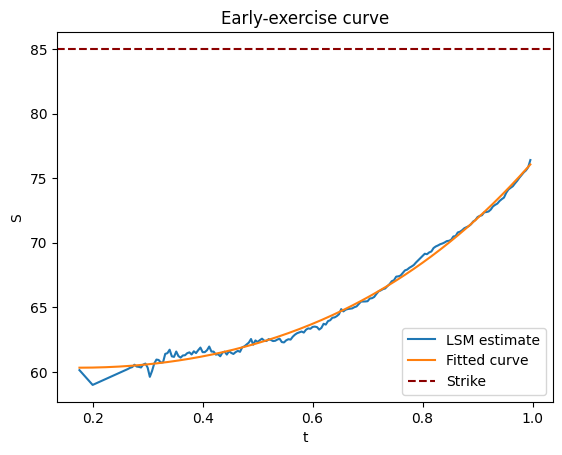

In [14]:
plt.plot(stop_t_lsm[IDX_START:], stop_S_lsm[IDX_START:], label='LSM estimate')
plt.plot(time_arr_early, early_fun(time_arr_early, early_fit_res.x),
         label='Fitted curve')
plt.axhline(STRIKE, ls='--', label='Strike', c='darkred')
plt.xlabel('t')
plt.ylabel('S')
plt.title('Early-exercise curve')
plt.legend()
plt.show()

# Comparison with Brennan-Schwartz algorithm

For Black-Scholes model, we can compare price and early-exercise curve obtained via LSM and Brennan-Schwartz algorithms (see [bsm.ipynb](bsm.ipynb)).

In [15]:
bsm = load(
    name='bsm',
    build_directory='./build',
    sources=[f'{NOA_LOCATION}/src/noa/quant/pytorch_extensions/bsm.cc'],
    extra_include_paths=[f'{NOA_LOCATION}/src'],
    extra_cflags=['-Wall -Wextra -Wpedantic -O3 -std=c++17'],
    verbose=False
)

In [16]:
T = N_STEPS * DT
S_min = 30
S_max = 200
npoints_S = 3000
npoints_t = 3000
TOL=1e-5

V_bsm, S_arr, t_arr = bsm.price_american_put_bs(
    STRIKE, T, RATE, SIGMA, S_min, S_max, npoints_S, npoints_t)
_, stop_S_bsm = bsm.find_early_exercise(V_bsm, S_arr, t_arr, STRIKE, TOL)

price_american_put_bs(): delta_tau / (delta_x)^2 = 37.4972


In [17]:
price_bsm = V_bsm[np.argmin(np.abs(S_arr - S0)), -1]
rel_diff = (lsm_res.option_price - price_bsm) / price_bsm

In [18]:
print(f'LSM price: {lsm_res.option_price}')
print(f'Brennan-Schwartz price: {price_bsm}')
print(f'Relative difference: {rel_diff * 100}%')

LSM price: 4.351371802851156
Brennan-Schwartz price: 4.35758812877759
Relative difference: -0.14265519692835996%


Let's compare early-exercise curves.

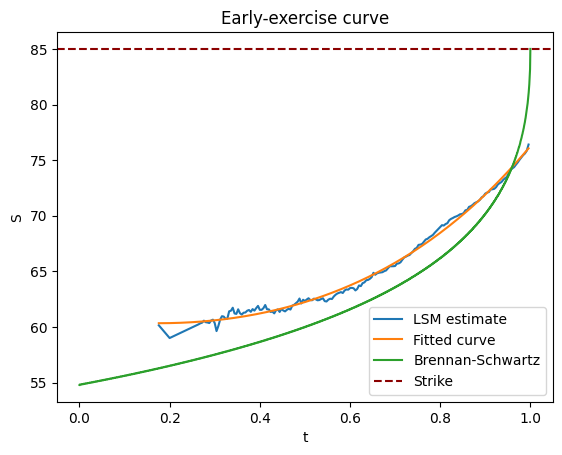

In [19]:
plt.plot(lsm_res.stop_t_vals[IDX_START:], lsm_res.stop_S_vals[IDX_START:],
         label='LSM estimate')
plt.plot(time_arr_early, early_fun(time_arr_early, early_fit_res.x),
         label='Fitted curve')
plt.plot(t_arr, stop_S_bsm, label='Brennan-Schwartz')
plt.axhline(STRIKE, ls='--', label='Strike', c='darkred')
plt.xlabel('t')
plt.ylabel('S')
plt.title('Early-exercise curve')
plt.legend()
plt.show()

We can see that LSM algorithm produces results which are close to the Brennan-Schwartz algorithm.

# References

- [LongstaffSchwartz2001] [Longstaff, F. A., & Schwartz, E. S. (2001). Valuing American options by simulation: a simple least-squares approach. The review of financial studies, 14(1), 113-147.](http://deriscope.com/docs/Longstaff_Schwarz_2001.pdf)
- [Seydel2017] [Seydel, Rüdiger. Tools for computational finance. Sixth edition. Springer, 2017.](https://link.springer.com/book/10.1007/978-1-4471-7338-0) Section 3.6.3.
- [Huge2017] [Huge, B. N., & Savine, A. (2017). LSM Reloaded-Differentiate xVA on your iPad Mini. Available at SSRN 2966155.](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2966155)
- [Jonen2011] [Jonen, C. (2011). Efficient pricing of high-dimensional American-style derivatives: A robust regression Monte Carlo method (Doctoral dissertation, Universität zu Köln).](https://kups.ub.uni-koeln.de/4442/1/Diss_Jonen.pdf)